In [1]:
import os
os.chdir(os.path.abspath('..')) 

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# My codes
import decoder_PC2d
import model_viz_functions_riab as modelviz_utils
import model_viz_loaders as modelviz_loaders

############################################################

import einops
import os

import jax
import jax.numpy as jnp
import numpy as np
from flax import linen as nn

jax.config.parse_flags_with_absl()
jax.config.update("jax_numpy_rank_promotion", "raise")

import matplotlib.pyplot as plt
import joblib
# import pathlib
import pickle


import ratinabox
from ratinabox.Neurons import PlaceCells
# from ratinabox.Agent import Agent

from dsm import datasets, envs, stade #, #train #metrics, console
# from dsm import plotting, rewards 
# from dsm.state import State
# from dsm.plotting import utils as plot_utils #fig_to_ndarray

import copy
from matplotlib import colors
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib import gridspec

import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

cmap_ratemap = 'inferno'  

[12:06:03] INFO     MUJOCO_GL is not set, so an OpenGL backend will be chosen automatically.         ]8;id=760395;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py\__init__.py]8;;\:]8;id=59160;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py#88\88]8;;\

           INFO     Successfully imported OpenGL backend: glfw                                       ]8;id=998288;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py\__init__.py]8;;\:]8;id=493328;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py#96\96]8;;\

           INFO     MuJoCo library version is: 2.3.7                                                 ]8;id=771472;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/dm_control/mujoco/wrapper/mjbindings/__init__.py\__init__.py]8;;\:]8;id=472563;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/dm_control/mujoco/wrapper/mjbindings/__init__.py#31\31]8;;\

/home/sruthi/Sruthi/dsm-hippocampus-main/dsm/stade.py:150: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  seed: int | jax.random.KeyArray | npr.SeedSequence | None,
/home/sruthi/Sruthi/dsm-hippocampus-main/dsm/stade.py:227: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  seed: int | jax.random.KeyArray | npr.SeedSequence | None = None,
/home/sruthi/Sruthi/dsm-hippocampus-main/dsm/train.py:119: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Arr

### ENV and MODEL path and CONFIGs here

In [3]:
# ENVIRONMENT = "Ratinabox-v0-pc-goal" 
# model_path = "logdir-rat_50pc_goal" 

# ENVIRONMENT = "Ratinabox-v0-pc-highTH" 
# model_path = "logdir-rat_50pc_highTH" 

# ENVIRONMENT = "Ratinabox-v0-pc-walls" 
# model_path = "logdir-rat_50pc_walls" 

ENVIRONMENT = "Ratinabox-v0-pc-random"
model_path = "logdir-rat_50pc_random_walk" 

# ENVIRONMENT = "Ratinabox-v0-pc-teleport"
# model_path = "logdir-rat_50pc_teleport" 

In [4]:
num_samples= 10 #config.plot_num_samples # Number of samples the model should generate

### Env and dataset

In [5]:
folder_dataset_path = os.path.dirname(datasets._DATASET_REGISTRY[ENVIRONMENT])
dataset = datasets.make_dataset(ENVIRONMENT)
# folder_dataset_path = "/media/sruthi/SSD2/sruthi_data/ratinaboxPCgoal/sac/"
# env_data_path = pathlib.Path(folder_dataset_path+"dataset.pkl")
# with env_data_path.open("rb") as fp:
#         dataset = pickle.load(fp)
# print(folder_dataset_path)
print("Dataset observations shape: ",dataset.observation.shape)
pc_path = folder_dataset_path+'/placecells_params.pkl'
log_file = folder_dataset_path+'/my_log.log'

env = envs.make(ENVIRONMENT)  #config.env
Ag = env.agent_lookup('agent_0')[0] # Agent(env) will create a new agent - agent0 already added in envs.py

PC_params = joblib.load(pc_path)
NUM_STATE_DIM_CELLS = PC_params['n']
print('NUM_STATE_DIM_CELLS:',NUM_STATE_DIM_CELLS)
PCs = PlaceCells(Ag, params=PC_params) 
orig_pc_centres = PCs.place_cell_centres.copy()

# Ag1 = Agent(env) #will create a new agent - agent0 already added in envs.py
# env.add_agents(Ag1)
# PCs_changed = PlaceCells(Ag1, params=PC_params.copy()) 

# fig, ax = PCs.plot_rate_map(chosen_neurons="all")
env = stade.GymEnvWrapper(env, with_infos=False, seed=None)
# data = datasets.make_dataset(config.env)

Dataset observations shape:  (24000, 50)
NUM_STATE_DIM_CELLS: 50


In [18]:
def plot_env(ENVIRONMENT):
    folder_dataset_path = os.path.dirname(datasets._DATASET_REGISTRY[ENVIRONMENT])
    dataset = datasets.make_dataset(ENVIRONMENT)
    print("Dataset observations shape: ",dataset.observation.shape)
    pc_path = folder_dataset_path+'/placecells_params.pkl'
    env = envs.make(ENVIRONMENT)  #config.env
    Ag = env.agent_lookup('agent_0')[0] # Agent(env) will create a new agent - agent0 already added in envs.py
    PC_params = joblib.load(pc_path)
    PCs = PlaceCells(Ag, params=PC_params) 
    decoder_PC2d.train_xy_Net(PCs, Ag,epochs=100)
    positions_all = decoder_PC2d.decode_position(PCs,dataset.observation,plot=True,method='dropoutNet')
    # env = stade.GymEnvWrapper(env, with_infos=False, seed=None)
    return env, Ag, PCs, positions_all

Dataset observations shape:  (24000, 50)


/home/sruthi/Sruthi/dsm-hippocampus-main/decoder_PC2d.py:115: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap('viridis')


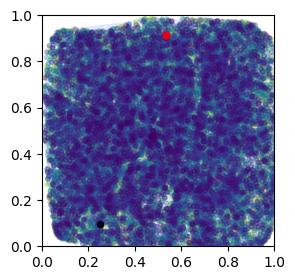

In [10]:
env, Ag, PCs, positions_all = plot_env("Ratinabox-v0-pc-teleport")

Dataset observations shape:  (24000, 50)


/home/sruthi/Sruthi/dsm-hippocampus-main/decoder_PC2d.py:115: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap('viridis')


(<ratinabox.contribs.TaskEnvironmentGym.SpatialGoalEnvironment at 0x7fc5ae3b0550>,
 array([[0.3838042 , 0.4370223 ],
        [0.38617954, 0.43916655],
        [0.38919047, 0.44191572],
        ...,
        [0.9208348 , 0.12377819],
        [0.9195504 , 0.12275374],
        [0.91891515, 0.1220687 ]], dtype=float32))

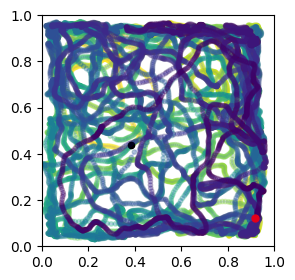

In [13]:
plot_env("Ratinabox-v0-pc-highTH")

In [14]:
# PCs2 = copy.deepcopy(PCs)


In [15]:
# plt.figure(figsize=(5, 5))
# plt.scatter(PCs.place_cell_centres[:,0], PCs.place_cell_centres[:,1], c='r', s=10)

Successfully imported dataset from arrays passed
Total of 1200.0 s of data available
                    The Environment extent is [minx,maxx,miny,maxy]=[0.0,1.0,0.0,1.0], whereas extreme coords are [-0.0,0.9,0.1,0.9].
                    Recommended to use larger environment.
    • To AUTOMATICALLY save all plots (recommended), set  `ratinabox.autosave_plots = True`
    • To MANUALLY save plots, call                        `ratinabox.utils.save_figure(figure_object, save_title).
      This warning will not be shown again
HINT: You can stylize plots to make them look like repo/paper by calling `ratinabox.stylize_plots()`
      This hint will not be shown again


(<Figure size 250x250 with 1 Axes>, <Axes: >)

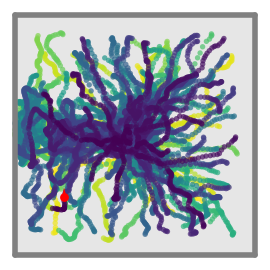

In [16]:
env, Ag, PCs, positions_all =  plot_env("Ratinabox-v0-pc-goal")
NUM_SECS=1200
Ag.import_trajectory(times = np.linspace(0, NUM_SECS,len(positions_all)), positions=positions_all) #,interpolate=True
for i in range(int(NUM_SECS / Ag.dt)):
        Ag.update()
        PCs.update()
Ag.plot_trajectory(color="changing")

Dataset observations shape:  (24000, 50)


/home/sruthi/Sruthi/dsm-hippocampus-main/decoder_PC2d.py:115: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap('viridis')


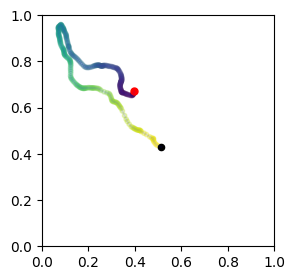

In [17]:
ENVIRONMENT = "Ratinabox-v0-pc-random"
folder_dataset_path = os.path.dirname(datasets._DATASET_REGISTRY[ENVIRONMENT])
dataset = datasets.make_dataset(ENVIRONMENT)
print("Dataset observations shape: ",dataset.observation.shape)
pc_path = folder_dataset_path+'/placecells_params.pkl'
env = envs.make(ENVIRONMENT)  #config.env
Ag = env.agent_lookup('agent_0')[0] # Agent(env) will create a new agent - agent0 already added in envs.py
PC_params = joblib.load(pc_path)
PCs = PlaceCells(Ag, params=PC_params) 
decoder_PC2d.train_xy_Net(PCs, Ag,epochs=100)
positions_all = decoder_PC2d.decode_position(PCs,dataset.observation[:300,:],plot=True,method='dropoutNet')

In [7]:
# source states to feed to the model
env_coords_small = Ag.Environment.discretise_environment(dx=0.1) # dx=Ag.environment.scale/10 , dx=0.01
# dx=0.05 , (400, 2)
#dx = 0.2, (25,2)
env_coords_small = env_coords_small.reshape(-1, env_coords_small.shape[-1])
# pc_full_env = PCs.get_state(evaluate_at="all").T # N of 10000 values corresponding to ag.Environment.flattened_discrete_coords # len 10000
source_states_env = PCs.get_state(evaluate_at=None, pos=env_coords_small).T
print(source_states_env.shape)
# plt.plot(env_coords_small[:,0],env_coords_small[:,1],'o')
# plt.ylim(0, 1)
# plt.xlim(0, 1)

unique_xpos, indices = np.unique(env_coords_small[:, 0], return_index=True)
xpos = unique_xpos[np.argsort(indices)]
unique_ypos, indices = np.unique(env_coords_small[:, 1], return_index=True)
ypos = unique_ypos[np.argsort(indices)]


(100, 50)


### Model stuff - restoring checkpoint

Dataset observations shape:  (24000, 50)


/home/sruthi/Sruthi/dsm-hippocampus-main/decoder_PC2d.py:115: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap('viridis')


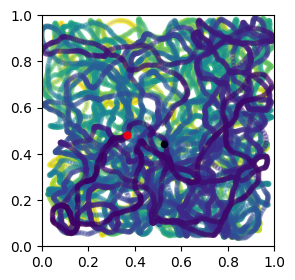

In [19]:
env, Ag, PCs, positions_all = plot_env(ENVIRONMENT)

In [20]:
env = stade.GymEnvWrapper(env, with_infos=False, seed=None)
state, config = modelviz_loaders.load_model_state_and_config_from_checkpoint_dir(model_path, env)


[12:11:44] WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=704857;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=184957;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir
debug latest_step 500000


           INFO     Restoring item from                                                         ]8;id=471698;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=273792;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/500000                    
                    .                                                                                              

/home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/type_handlers.py:1464: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs.
  warnings.warn(


           INFO     Finished restoring checkpoint from                                          ]8;id=734618;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=348070;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/500000                    
                    .                                                                                              

original source:  [0.55 0.25]
Using provided zs
Max SD of samples decoded with dropoutNet: (0.25012577, 0.39525524) ; Atom 6
Max SD of samples decoded with dropoutNet: (0.30382824, 0.41994426) ; Atom 9
decoded source:  [0.5468603 0.2792844]


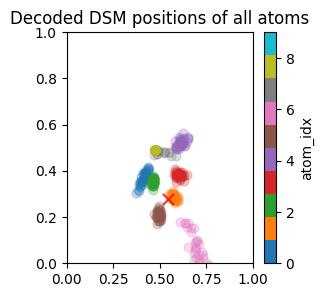

In [21]:
num_samples= 40
source_idx = 75
source=source_states_env[source_idx]
print('original source: ',env_coords_small[source_idx])
latent_rng = jax.random.PRNGKey(10)
z0 = np.ones((num_samples, config.num_outer, config.latent_dims)) #*10  # latent_rng not used if zs provided
source, samples = modelviz_loaders.compute_DSM_samples_single_source(
        state.generator, latent_rng,zs=z0, config=config, source_state_current=source, num_samples = num_samples
    )
modelviz_utils.plot_samples(PCs, dataset.observation,samples,source, make_dataset=False,atom='all',method='dropoutNet')
# modelviz_utils.plot_samples(samples,source, make_dataset=True,atom='all',LR=True)


##### Decoder uncertainty

In [18]:
# # showing SDs of decoded samples - 1 from each atom 
# positions_pred, positions_std  = decoder_PC2d.decode_position(PCs,samples[:,3,:], method='dropoutNet',return_std=True)
# print(f'SD of decoded samples with dropoutNet:{positions_std}')

# # showing SDs of decoded samples - from 4th atom
# positions_pred, positions_std  = decoder_PC2d.decode_position(PCs,samples[3,:,:], method='dropoutNet',return_std=True)
# print(f'SD of decoded samples with dropoutNet:{positions_std}')

In [19]:
# import matplotlib.pyplot as plt
# from matplotlib.cm import ScalarMappable
# from matplotlib.colors import Normalize
# cmap = plt.get_cmap('tab10')

# atom_idx_values = np.arange(10) #[3,4,8]
# norm = Normalize(vmin=min(atom_idx_values), vmax=max(atom_idx_values))

# for atom_idx in atom_idx_values:
#     method='dropoutNet'
#     positions_pred, positions_std  = decoder_PC2d.decode_position(PCs,samples[atom_idx], method=method,return_std=True)
#     plt.scatter(positions_std[:, 0], positions_std[:, 1], color=cmap(norm(atom_idx)), s=40)
#     # range_column1 = (np.min(positions_std[:, 0]), np.max(positions_std[:, 0]))
#     # range_column2 = (np.min(positions_std[:, 1]), np.max(positions_std[:, 1]))
#     maxc1, maxc2 = np.max(positions_std[:, 0]), np.max(positions_std[:, 1])
#     if maxc1 > 0.1 and maxc2 > 0.1:
#         print(f'Max SD of decoded samples of atom {atom_idx} with {method}: {maxc1, maxc2}')

# # Create a ScalarMappable object and use it to add a colorbar to the plot
# sm = ScalarMappable(cmap=cmap, norm=norm)
# plt.colorbar(sm, ax=plt.gca(), label='atom_idx')
# plt.show()

### Plot multiple samples

(100, 50)


Processing atoms: 100%|██████████| 10/10 [00:56<00:00,  5.69s/it]
/home/sruthi/Sruthi/dsm-hippocampus-main/model_viz_functions_riab.py:494: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


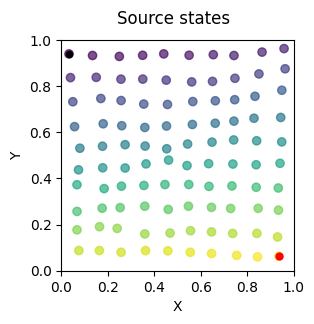

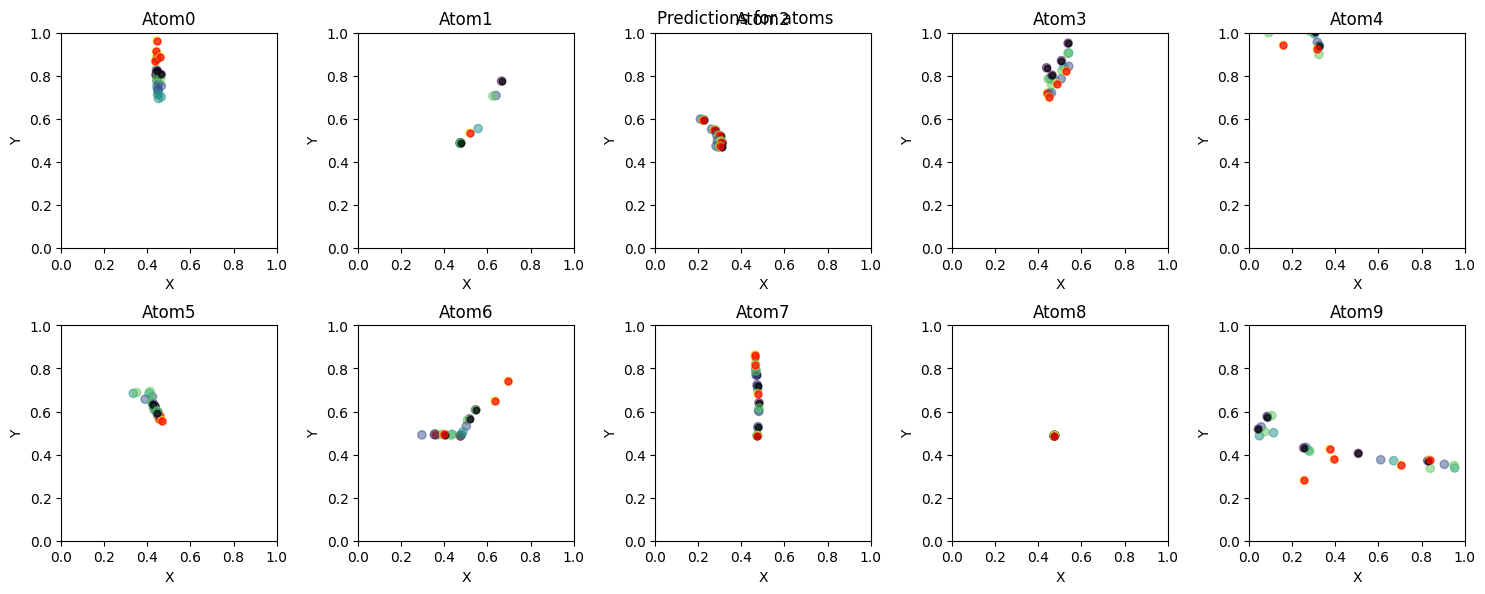

In [22]:
# %%
env_coords_small = Ag.Environment.discretise_environment(dx=0.1) # dx=Ag.environment.scale/10 , dx=0.01
# dx=0.05 , (400, 2)
#dx = 0.2, (25,2)
env_coords_small = env_coords_small.reshape(-1, env_coords_small.shape[-1])
# pc_full_env = PCs.get_state(evaluate_at="all").T # N of 10000 values corresponding to ag.Environment.flattened_discrete_coords # len 10000
source_states_env = PCs.get_state(evaluate_at=None, pos=env_coords_small).T
print(source_states_env.shape)
unique_xpos, indices = np.unique(env_coords_small[:, 0], return_index=True)
xpos = unique_xpos[np.argsort(indices)]
unique_ypos, indices = np.unique(env_coords_small[:, 1], return_index=True)
ypos = unique_ypos[np.argsort(indices)]

# %%
decoded_positions = []
decoded_positions = decoder_PC2d.decode_position(PCs, source_states_env)
decoded_positions.shape
# decoded_positions = decoded_positions.reshape(preds_all_atom.shape[0], preds_all_atom.shape[1], 2)
# # print(decoded_positions.shape) #(25, 5, 2)

# %%
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
colors = range(len(decoded_positions))  # Create a list of numbers from 0 to len(xs)-1
# reversed_map = plt.cm.get_cmap('viridis') #.reversed() 
xs,ys = decoded_positions[:,0], decoded_positions[:,1]
scatter = ax.scatter(xs,ys, alpha=0.7, c=colors, cmap='viridis')  # Use the numbers as colors
ax.scatter(xs[0], ys[0], color='k', s=20)
ax.scatter(xs[-1], ys[-1], color='red', s=25)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
fig.suptitle('Source states')


# %%
num_samples = 5
latent_rng_seed = 5
preds1 = modelviz_utils.get_multiple_predictions_atoms(config, latent_rng_seed, state.generator, source_states_env, 
                                            PCs, atoms_sel='all', num_samples=num_samples, title='Predictions for atoms')
modelviz_utils.plot_multiple_predictions_atoms(preds1, num_samples=num_samples, title='Predictions for atoms')
